### CS308: Machine Learning | Stock Market Predictor
1) **Problem definition:** Predict stock prices of companies using conventional stock features and social media sentiment.  
2) **Motivation:** Predicting how the stock market will perform is one of the most difficult things to do due to the high volatility of stock prices.  
3) **Method used:** Long Short Term Memory (LSTM) model used on a total of 58 features (_50 word2vec embeddings, 6 conventional features from stock market, and 2 sentiment features_).  
4) **Results obtained:** The final model is compared to a baseline model which uses only 6 features (_conventional stock market values_). The error is much lower and although the number of EPOCHS needed increases. It is also compared to another model having 8 features, i.e., a model without Word2Vec embeddings. The plots of absolute errors is shown below.  

***


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm

import json
import requests

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

In [ ]:
# Stock prices scraping

def get_stock_data():
    link = 'https://query1.finance.yahoo.com/v8/finance/chart/GOOG?range=1d&includePrePost=false&interval=2m&corsDomain=in.finance.yahoo.com&.tsrc=finance'
    resp = requests.get(link)
    data = json.loads(resp.text)
    data = data['chart']['result'][0]['indicators']['quote'][0]
    volume = data['volume']
    close = data['close']
    low = data['low']
    high = data['high']
    open_val = data['open']
    json.dump(dict(vol=volume,close=close,low=low,high=high,open=open_val), open('dataGot.json','w'))

#get_stock_data()

In [ ]:
# loading and preprocessing data : only conventional stock features, baseline model

data = json.loads(open('dataGot.json','r').read())
y = np.array(data['close'])  #stocks closing today

print(len(y))
X_relevant = np.array([[data['vol'][i],data['open'][i],data['low'][i],data['high'][i]] for i in range(len(y))])
# print(X_relevant) 
"""
  X_relevant : shows the volume, opening stock price, lowest and highest stock prices.
  Number of variables  = 4
  The variable that is to be predcited is the closing price within that time span
"""
X = []
max_price = -1
min_price = 10000
for i in range(len(X_relevant)-1, -1, -1):
    x_t = []
    x_t.append(X_relevant[i][0])
    x_t.append(X_relevant[i][1])
    x_t.append(X_relevant[i][2])
    x_t.append(X_relevant[i][3])
    max_price = max(y[i], max_price)  #max_price is the maximum of yesterday's closing price compared to current maxm price
    x_t.append(max_price)
    min_price = min(y[i], min_price)
    x_t.append(min_price)
    X.append(x_t)

X = np.array(X)
print(X.shape)
X = X.reshape(X.shape[0],1,X.shape[1])

data = {}
data["X"] = X.tolist()
data["y"] = y.tolist()
json.dump(data,open('data_senti_word_baseline.json','w'))


195
(195, 6)


In [ ]:
# loading and preprocessing data : baseline + sentiment analysis

data = json.loads(open('dataGot.json','r').read())
senti = np.array(pd.read_csv('generatedscores.csv').get(['positive','negative'])) # +/- sentiment score generated using tweets
y = np.array(data['close'])  #stocks closing today

print(len(y))
X_relevant = np.array([[data['vol'][i],data['open'][i],data['low'][i],data['high'][i]] for i in range(len(y))])
# print(X_relevant) 
"""
  X_relevant : shows the volume, opening stock price, lowest and highest stock prices.
  Number of variables  = 4
  The variable that is to be predcited is the closing price within that time span
"""
X = []
max_price = -1
min_price = 10000
for i in range(len(X_relevant)-1, -1, -1):
    x_t = []
    x_t.append(X_relevant[i][0])
    x_t.append(X_relevant[i][1])
    x_t.append(X_relevant[i][2])
    x_t.append(X_relevant[i][3])
    max_price = max(y[i], max_price)  #max_price is the maximum of yesterday's closing price compared to current maxm price
    x_t.append(max_price)
    min_price = min(y[i], min_price)
    x_t.append(min_price)
    x_t.append(senti[i][0])
    x_t.append(senti[i][1])
    X.append(x_t)

X = np.array(X)
print(X.shape)
X = X.reshape(X.shape[0],1,X.shape[1])
data = {}
data["X"] = X.tolist()
data["y"] = y.tolist()
json.dump(data,open('data_senti_word_v1.json','w'))


195
(195, 8)


In [ ]:
# loading and preprocessing data : baseline + sentiment analysis + embeddings

data = json.loads(open('dataGot.json','r').read())
senti = np.array(pd.read_csv('generatedscores.csv').get(['positive','negative'])) # +/- sentiment score generated using tweets
embeddings = json.loads(open('generatedscores.json','r').read())["l"] # Word2Vec model generates using tweets (50-dimensional)
#print embeddings[0]
y = np.array(data['close'])  #stocks closing today

print(len(y))
X_relevant = np.array([[data['vol'][i],data['open'][i],data['low'][i],data['high'][i]] for i in range(len(y))])
# print(X_relevant) 
"""
  X_relevant : shows the volume, opening stock price, lowest and highest stock prices.
  Number of variables  = 4
  The variable that is to be predcited is the closing price within that time span
"""
X = []
max_price = -1
min_price = 10000
for i in range(len(X_relevant)-1, -1, -1):
    x_t = []
    x_t.append(X_relevant[i][0])
    x_t.append(X_relevant[i][1])
    x_t.append(X_relevant[i][2])
    x_t.append(X_relevant[i][3])
    max_price = max(y[i], max_price)  #max_price is the maximum of yesterday's closing price compared to current maxm price
    x_t.append(max_price)
    min_price = min(y[i], min_price)
    x_t.append(min_price)
    x_t.append(senti[i][0])
    x_t.append(senti[i][1])
    x_t += embeddings[i]
    X.append(x_t)

X = np.array(X)
print(X.shape)
X = X.reshape(X.shape[0],1,X.shape[1])
data = {}
data["X"] = X.tolist()
data["y"] = y.tolist()
json.dump(data,open('data_senti_word_v2.json','w'))


195
(195, 58)


In [ ]:
# stockpred.py : baseline model

data = json.load(open("data_senti_word_baseline.json","r"))
X_train = np.array(data['X'])
y_train = np.array(data['y']).reshape(-1,1)

epochs = 500
data_dim = 6
batch_size=10

mean = np.mean(X_train.reshape(X_train.shape[0],-1),axis=0)
std = np.std(X_train.reshape(X_train.shape[0],-1),axis=0)
X_train -= mean
X_train /= std


model = Sequential()
model.add(Dense(1, input_shape = (data_dim,)))
#model.add(Dense(32))
#model.add(Dense(1))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/500
20/20 [==============================] - 0s 2ms/step - loss: 1055836.7857 - mae: 1027.5359
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 1056031.6012 - mae: 1027.6302
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 1055104.7262 - mae: 1027.1796
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 1055031.4464 - mae: 1027.1436
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 1054961.1905 - mae: 1027.1084
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 1055573.4702 - mae: 1027.4079
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 1054851.2202 - mae: 1027.0555
Epoch 8/500
20/20 [==============================] - 0s 2ms/step - loss: 1054789.6786 - mae: 1027.0263
Epoch 9/500
20/20 [==============================] - 0s 2ms/step - loss: 1055070.9226 - mae: 1027.1630
Epoch 10/500
20/20 [==============================] - 0s 2ms/step - loss:

In [ ]:
# stockpred.py : baseline + sentiment analysis

data = json.load(open("data_senti_word_v1.json","r"))
X_train = np.array(data['X'])
y_train = np.array(data['y']).reshape(-1,1)

epochs = 500
num_hidden = 20
data_dim = 8
batch_size=1
mean = np.mean(X_train.reshape(X_train.shape[0],-1),axis=0)
std = np.std(X_train.reshape(X_train.shape[0],-1),axis=0)

#normalisation of X_training data
X_train -= mean
X_train /= std


model = Sequential()
model.add(LSTM(num_hidden, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size,1,data_dim)))
model.add(LSTM(num_hidden, return_sequences=True, stateful=True))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

#history.history['mae']
history_v1 = model.fit(X_train, y_train,
              batch_size=batch_size, epochs=epochs)

Epoch 1/500
195/195 [==============================] - 3s 4ms/step - loss: 1051081.2978 - mae: 1025.2130
Epoch 2/500
195/195 [==============================] - 1s 4ms/step - loss: 1034872.2401 - mae: 1017.2812
Epoch 3/500
195/195 [==============================] - 1s 4ms/step - loss: 1026923.0529 - mae: 1013.3654
Epoch 4/500
195/195 [==============================] - 1s 4ms/step - loss: 1017721.2468 - mae: 1008.8154
Epoch 5/500
195/195 [==============================] - 1s 4ms/step - loss: 1010504.2557 - mae: 1005.2320
Epoch 6/500
195/195 [==============================] - 1s 4ms/step - loss: 1003252.1594 - mae: 1001.6172
Epoch 7/500
195/195 [==============================] - 1s 4ms/step - loss: 994479.2219 - mae: 997.2290
Epoch 8/500
195/195 [==============================] - 1s 4ms/step - loss: 986116.0261 - mae: 993.0274
Epoch 9/500
195/195 [==============================] - 1s 4ms/step - loss: 976674.0542 - mae: 988.2627
Epoch 10/500
195/195 [==============================] - 1s 4m

In [ ]:
# stockpred.py : baseline + sentiment analysis + word2vec embeddings

data = json.load(open("data_senti_word_v2.json","r"))
X_train = np.array(data['X'])
y_train = np.array(data['y']).reshape(-1,1)

epochs = 500
num_hidden = 20
data_dim = 58
batch_size=1
mean = np.mean(X_train.reshape(X_train.shape[0],-1),axis=0)
std = np.std(X_train.reshape(X_train.shape[0],-1),axis=0)

#normalisation of X_training data
X_train -= mean
X_train /= std


model = Sequential()
model.add(LSTM(num_hidden, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size,1,data_dim)))
model.add(LSTM(num_hidden, return_sequences=True, stateful=True))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

#history.history['mae']
history_v2 = model.fit(X_train, y_train,
              batch_size=batch_size, epochs=epochs)

Epoch 1/500
195/195 [==============================] - 3s 4ms/step - loss: 1047890.8211 - mae: 1023.6550
Epoch 2/500
195/195 [==============================] - 1s 4ms/step - loss: 1033117.8750 - mae: 1016.4179
Epoch 3/500
195/195 [==============================] - 1s 4ms/step - loss: 1023901.5698 - mae: 1011.8740
Epoch 4/500
195/195 [==============================] - 1s 4ms/step - loss: 1016310.5816 - mae: 1008.1157
Epoch 5/500
195/195 [==============================] - 1s 4ms/step - loss: 1007247.4844 - mae: 1003.6113
Epoch 6/500
195/195 [==============================] - 1s 3ms/step - loss: 999726.7376 - mae: 999.8570
Epoch 7/500
195/195 [==============================] - 1s 4ms/step - loss: 991534.0504 - mae: 995.7518
Epoch 8/500
195/195 [==============================] - 1s 4ms/step - loss: 982842.1084 - mae: 991.3777
Epoch 9/500
195/195 [==============================] - 1s 4ms/step - loss: 975806.1020 - mae: 987.8218
Epoch 10/500
195/195 [==============================] - 1s 4ms/

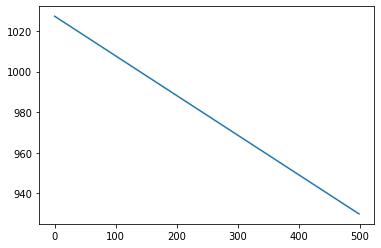

In [ ]:
plt.plot(history.history['mae'])


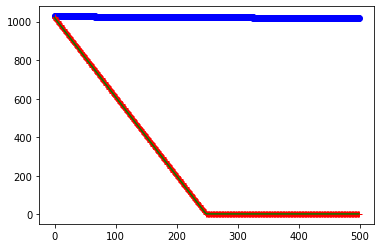

In [ ]:
plt.plot(history.history['mae'],'bo')
plt.plot(history_v1.history['mae'],'r+')
plt.plot(history_v2.history['mae'],'g-')


plt.show()

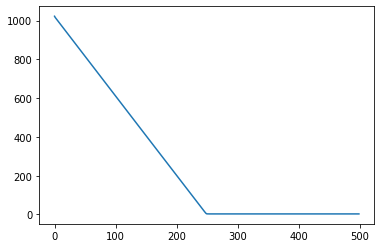

In [ ]:
plt.plot(history_v1.history['mae'])


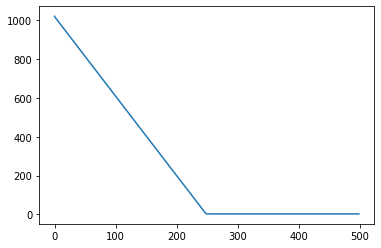

In [ ]:
plt.plot(history_v2.history['mae'])


In [ ]:
import json
with open('generatedscores.json') as f:
  datase = json.load(f)
  print(datase)


{'l': [[3.5214558874658737, 4.160007619880903, -2.462391028049016, 0.8423823547034832, -2.3681709840073966, 0.7439448283662721, -0.7937197738943935, 0.5056256880112864, 1.1019781668815616, -1.932103215219536, -1.859200947904223, -0.41707626120627467, -1.2385941356441348, -0.19934147365544458, 1.936804931126515, 1.6956932069827813, -1.8282729236121473, -0.35000214306335264, 1.0249365840683735, -0.20190506419114848, -2.1776967363278845, 0.7155541043760845, -0.32117113791542895, 0.30396158434181847, -3.1678567704936813, -0.9089307962069462, 1.143431908450517, 1.0939760565432528, -1.0848390178991454, -1.063613735397399, -1.510212488196962, 3.1281199438032434, -0.44362801282356185, 1.0284306195619668, -0.680455551175992, 3.1557738749366817, -2.2919287137273283, 0.33510698186504767, 1.2138662924465937, -3.757428426826359, -0.8921542799770213, 2.9172842787191655, -1.4592917138793942, -1.3870976336796272, -1.2343227644928048, -1.5281199888617853, 3.384722481284178, 0.9661484174204427, -1.11472

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (32, 8, 32)               6272      
_________________________________________________________________
lstm_12 (LSTM)               (32, 8, 32)               8320      
_________________________________________________________________
lstm_13 (LSTM)               (32, 32)                  8320      
_________________________________________________________________
dense_8 (Dense)              (32, 4)                   132       
Total params: 23,044
Trainable params: 23,044
Non-trainable params: 0
_________________________________________________________________


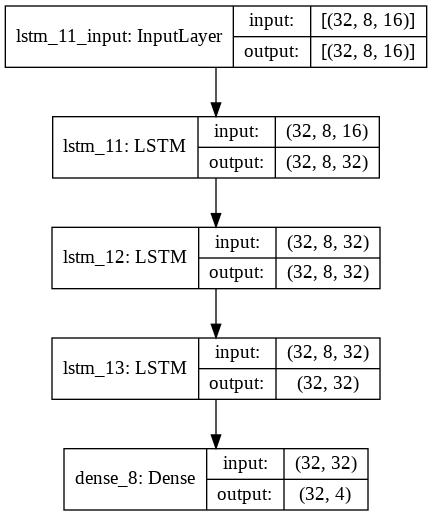

In [ ]:
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# LSTM for sentiment analysis

data_dim = 16
timesteps = 8
num_classes = 4
batch_size = 32
EPOCHS = 10
num_hidden = 32

# Expected input batch shape: (batch_size, timesteps, data_dim)
# we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.
model = Sequential()
model.add(LSTM(num_hidden, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(LSTM(num_hidden, return_sequences=True, stateful=True))
model.add(LSTM(num_hidden, stateful=True))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Generate dummy training data
x_train = np.random.random((2,batch_size * 10, timesteps, data_dim))
y_train = np.random.randint(0,4,(2,batch_size * 10, num_classes))

# Generate dummy validation data
x_val = np.random.random((2,batch_size * 3, timesteps, data_dim))
y_val = np.random.randint(0,4,(2,batch_size * 3, num_classes))

for e in range(1):
    for i in range(x_train.shape[0]):
        model.fit(x_train[i], y_train[i],
                  batch_size=batch_size, epochs=1, shuffle=False,
                  validation_data=(x_val[i], y_val[i]))
        model.reset_states()
        
x_test = np.random.random((1,batch_size*10,8,16))
for j in range(x_test.shape[0]):
    for k in range(int(x_test.shape[1]/batch_size)):
        y_pred = model.predict_on_batch(x_test[j][k:k+batch_size])
    model.reset_states()
    print(y_pred.shape)

10/10 [==============================] - 0s 16ms/step - loss: 8.5484 - accuracy: 0.2344 - val_loss: 8.9130 - val_accuracy: 0.2500
(32, 4)


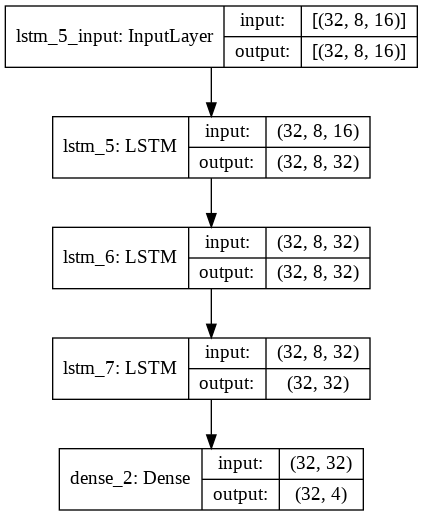

In [ ]:
y_train
tf.keras.utils.plot_model(model,show_shapes=True)